# Do the Wine Enthusiast’s points matter for wines sales?

## Narrative analytics and experimentation

Unit 1: Lesson 5: 1



Data: [Kaggle](https://www.kaggle.com/zynicide/wine-reviews)


The academic literature on the taste and quality of different wines is robust and damning: when tasting wines without reference to their name, type, or price, no one can consistently identify them or rate their quality. This is true of the [general public](http://www.wine-economics.org/aawe/wp-content/uploads/2012/10/Vol.3-No.1-2008-Evidence-from-a-Large-Sample-of-Blind-Tastings.pdf) as well as ['critics'](https://www.newyorker.com/tech/frontal-cortex/does-all-wine-taste-the-same) who claim a more sophisticated pallet.

However, this is not how people drink wines. Once prices are revealed consumer's evaluations follow the [price](http://www.caltech.edu/news/wine-study-shows-price-influences-perception-1374). More importantly for wineries, it is also not how they select wines. In a market whose quality of goods is unknown until actual consumption - *experience goods* such as wines, books, restaurants, movies - price and reviews are used as quality signals. Therefore, reviews from Robert Parker, Wine Speculator, or Wine Enthusiast or medals from contest can influence sales. This in turn can influence the [price](http://www.wine-economics.org/aawe/wp-content/uploads/2018/01/AAWE_WP223.pdf).   

This report is split into two sections. First, I explore a dataset of Wine Enthusiast’s rankings taken in November 2017. The dataset consists of the price and rankings of a particular wine, along with the winery, its region, and its country.  Note that the dataset unfortunately does not contain any sales data.  The initial analysis will be broad but will narrow to focus Simonsig – a South Africa winery I happen to be fond of. 
The main part of the report will focus on designing an experiment for Simonsig to test the effect of the Wine Enthusiast’s rankings. The Request for Comment (RFC) will attempt to cover the critical design and objectives for such an experiment. This is possible as the wine maker will have sales data available to them. 

## Setting up and exploring the data

In [136]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

In [213]:
wine = pd.read_csv('winemag-data-130k-v2.csv')
wine.head(3)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


In [214]:
# Removing unnamed column
#wine.set_index('Unnamed: 0', drop=True, inplace=True) - this didnt work?
wine.drop(['Unnamed: 0'], axis=1, inplace=True)

#Drop all observations without price points (roughly 9000 from 129971). May introduce some bias.
wine = wine.dropna(axis=0, how='any', subset=['price'])

# Breaking scores into Wine Enthusiast's ranking categories (but with easier names)
wine['Ranking']= wine['points'].apply(lambda x: 1 if x>=98 else 
                                      (2 if x>=94 and x<98 else
                                       (3 if x>=90 and x<94 else
                                        (4 if x>=87 and x<90 else
                                         (5 if x>=83 and x<87 else 6)))))

# Dropping outlier (at over $3300 a bottle of wine!)
print("Most expensive bottle wine is: ", max(wine['price']))
wine = wine[wine['price'] != max(wine['price'])]

Most expensive bottle wine is:  3300.0


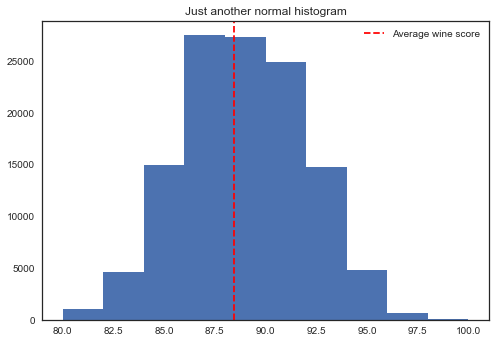

In [216]:
plt.hist(wine['points'])
plt.title('Just another normal histogram')
plt.axvline(wine['points'].mean(), label = 'Average wine score', color='r', linestyle = 'dashed')
plt.legend()
plt.show()

The shape of the ranking distribution is somewhat surprising. Given that anything that scores below 80 is discarded (it is not given the 'honour' of being ranked), most wines are already excluded from this sample. The distribution above is therefore already the tail of the wine population - so it should be right skewed (with many more wines falling in the early 80s).  

In [217]:
#Countries producing the most ranked wine
wine['points'].groupby(wine['country']).count().sort_values(ascending=False).head(12)

country
US              54265
France          17775
Italy           16914
Spain            6573
Portugal         4875
Chile            4416
Argentina        3756
Austria          2799
Australia        2294
Germany          2120
New Zealand      1378
South Africa     1293
Name: points, dtype: int64

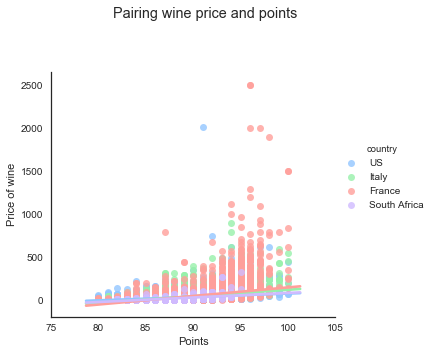

In [195]:
#Plotting scores and price by country (top three biggest + South Africa)
#There must be a better way to do this?
winetop = wine[wine['country'].isin(['US', 'France', 'Italy', 'South Africa'])]

sns.set(style='white')
#g = sns.pairplot(winetop[["points", "price"]], palette='bright', hue='country', diag_kind="hist")
g = sns.lmplot(y='price', x='points', data=winetop, palette='pastel', hue='country', fit_reg=True, ci=False)
g.set_ylabels('Price of wine')
g.set_xlabels('Points')
#Points can only be between 80 and 100
plt.xlim(75,105)
plt.suptitle('Pairing wine price and points')
plt.subplots_adjust(top=0.8)
plt.show()

In [149]:
wine['price'].describe()

count    120974.000000
mean         35.336403
std          39.934126
min           4.000000
25%          17.000000
50%          25.000000
75%          42.000000
max        2500.000000
Name: price, dtype: float64

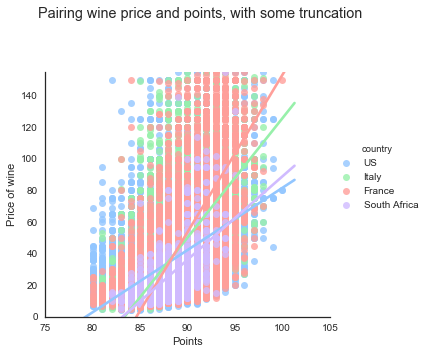

In [196]:
# Adjusting the to mean + three std of price to get a better view
sns.set(style='white')
g = sns.lmplot(y='price', x='points', data=winetop, palette='pastel', hue='country', fit_reg=True, ci=False)
g.set_ylabels('Price of wine')
g.set_xlabels('Points')
plt.xlim(75,105)
plt.ylim(0,155)
plt.suptitle('Pairing wine price and points, with some truncation')
plt.subplots_adjust(top=0.8)
plt.show()

This graph shows that there is a positive correlation between price and points, but the relationship varies by country. France has the strongest correlation. It is possible that French wineries can charge higher prices because they produce higher quality (as per points scored), but it possible that they are able to charge higher prices because of their strong brand as the top wine region (which also influences how the wines are scored).

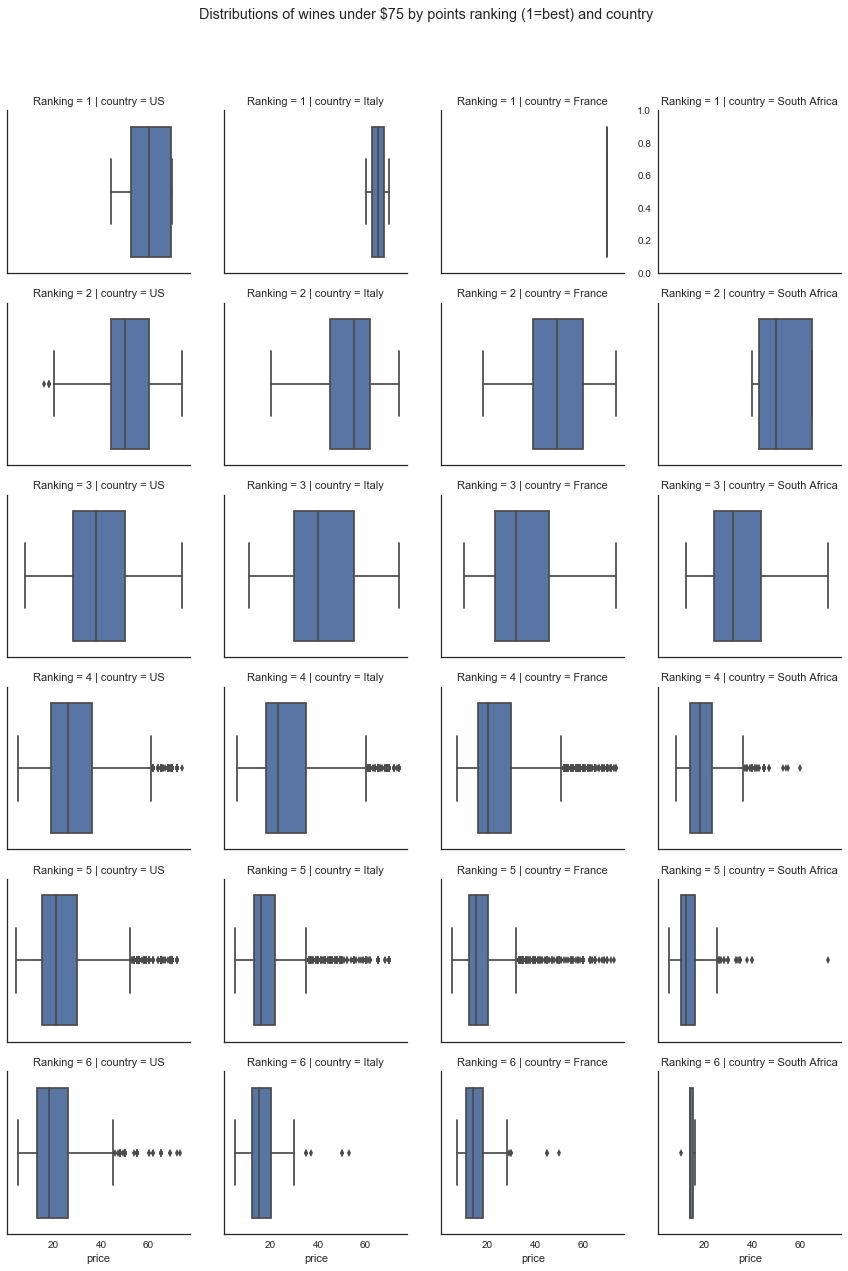

In [197]:
#Restricting wine prices to one std from mean for the four chosen countries
reasonablewine = winetop[winetop['price']<75]

sns.set_style("white")
#sns.factorplot(kind='box',
#               y='price',
#               x='Ranking',
#               hue='country',         
#               data=winetop,   
#               size=8,                  
#               aspect=1.5, legend_out=False)  

g = sns.FacetGrid(reasonablewine, col="country",  row="Ranking", sharex=True, sharey=False)
g = g.map(sns.boxplot, "price")
plt.suptitle('Distributions of wines under $75 by points ranking (1=best) and country')
plt.subplots_adjust(top=0.95)
plt.show()

This (admittedly busy) figure shows a couple of interesting things (keep in mind it's already restricted on price):
- The price distributions shift to higer prices as the ranking increases, but there is a fair amount of overlap between the distributions.
- The price distribution for rank 3 (90-93) is wide accross all four countries. These are good wines by most measures, but the price variance shows that there are other factors influencing the price (e.g. competitor prices and brand strenght)
- There are still some really good wines for under $20!
- Without sales data it is difficult to tell determine the influence the stars or the price

## Shifting to look at Simonsig

In [223]:
wine[wine['country']=='South Africa']['winery'].value_counts().sort_values(ascending=False).head(5)

Graham Beck         30
Simonsig            29
Robertson Winery    26
Fleur Du Cap        23
Jardin              23
Name: winery, dtype: int64

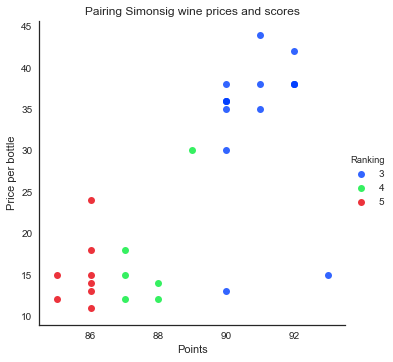

In [221]:
simonsig = wine[wine['winery']=='Simonsig'][['title', 'points', 'price','Ranking']]
g = sns.lmplot('points', 'price', data=simonsig, hue='Ranking', palette='bright', fit_reg=False, ci=True)
g.set_xlabels('Points')
g.set_ylabels('Price per bottle')
plt.title('Pairing Simonsig wine prices and scores')
plt.show()

## RFC for Simonsig: Does Wine Ethusiast's ranking matter?

### Overview

From the brief analysis above there seems to be some correlation between price and the points awarded by the Wine Enthusiast’s. However, it is unclear which way the causality runs. In fact, the relationship may be a lot weaker than at first glance since there may be an omitted variable bias which drives both score and price (e.g. brand name – although the taste tests are supposed to be blind which helps avoid this).

Ultimately, Simonsig is interested in sales. Picking the right price point is important (and points awarded may influence the sales price), but first it is neccessary to determine whether adding the score of the Wine Enthusiast to the bottle influences buying decisions. This RFC sets out a way to test this.

### Problem statement
Does adding the Wine Enthusiast's score on a bottle increase sales?

### Experiment design

**Treatment**: Select 3 wines to include in the experiment. Ideally this should be wines with high sales, high stocks available in the winery, and spread out across the rankings. Without sales and stock data the following wines are proposed:
-	Simonsig 2012 Merindol Syrah (91)
-	Simonsig 2011 Chenin Blanc
-	Simonsig 2008 Pinotage (85)

Note this includes two red wines and one white wine.

Label half the wines with the score by adding a sticker (work with the marketing department to ensure that sticker is consistent).

**Sample**: Split the distribution of wine into two samples – the control group will receive bottles without stickers, and the intervention group receives wines with stickers.  Factors to consider when splitting the sample includes geography and income. Note, this experiment is not applicable to restaurants since the buyers don’t see the wines before they buy it. A complication here is the use of large scale distributors, it may be necessary to cooperate with them to ensure the sample is split properly and to receive sales data. 
**Receiving sales feedback from individual stores is key to this experiment.**

**Timing**: Without prior sales data it is difficult to set the timeline. However, since the bottles will remain in store regardless of the stickers a long-time frame – 6 months – can be used initially. At the end of 6 months sales from the control and treatment stores can be collected and compared.

**Primary outcomes measured**: Sales (number)

**Secondary outcomes**: Rate of sales (bottles per week), customer and store feedback

**Null hypothesis**: Adding the Wine Enthusiast sticker does not affect in-store sales.

**Ramp-up**: If the experiment is succesful after 6 months it can be rolled out to include more bottles. This can also allow the sample to be split in several ways (i.e. sending bottles with and without labels to the same store).

### Expected outcome

Giving customers some indication of quality is likely to improve sales. Since the cost per sticker is likely to be small this will mean revenue growth for Simonsig.

### Challenges
Only one rating’s system is being used. The outcome of the experiment will depend, in part, on the brand strength of Wine Enthusiast. If this brand is weak compared to say, Robert Parker, then the experiment may not pass. It does not mean that *any* label or medal doesn’t affect sales.

### Future RFC
If the experiment is successful and the null hypothesis can be rejected a follow-up experiment can test whether the display of a good ranking can allow for higher pricing. Note, that splitting the sample with differential pricing may be problematic for this experiment.